# Module 3 Sprint 3 Lending Club part 2

Before diving into this notebook please check part 1 notebook 'Part1_Loan_decision.ipynb'

Second part of the Lending Club machine learning project. This part focuses on the accepted loan dataset from Lending Club, which is supplemented with additional information after the loans are accepted. The aim of this part is to build a model that would accurately classify and assign loan grades for newly accepted loans. Business objectives as follows:

- Build a model that would fit into the full loan decision and evaluation algorithm
- Streamlining loan evaluation process 



Data cleaning and EDA on Lending Club accepted loan dataset will be performed. Following hypothesis will be checked:

- There is a significant difference in approved loan interest rates between years 2015-2016 and last two years (2017-2018)
- There is a significant difference between 'debt consolidation' and 'credit card' purposed loan application deb to income ratios.(Indicating different type of debt of applicants)

Feature selection will be performed using a Random Forest Classifier, baseline model generated with multinomial Logistic Regression model, final model will be assembled using LightGBM and optimized using Optuna. 

Baseline and final models will be evaluated using F1 Macro score for the multiclass classification, final model explained using SHAP.

In [1]:
import sys
import os

sys.path.append("src")

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import random

# statistical tools
import scipy.stats as stats

# Machine Learning
from lazypredict.Supervised import LazyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
)

from lightgbm import LGBMClassifier

from phik import resources, report
from phik.report import plot_correlation_matrix

import shap
import optuna
import joblib

# helper functions
import plots as plot
import utils as utl

In [3]:
%load_ext autoreload
%autoreload 2

Setting some global variables for ease of access to multicolumn dataframes and visual representation of numerical values

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

In [5]:
RANDOM_SEED = 42
np.set_printoptions(suppress=True)

We will load in a small portion to investigate the features and see which ones can be discarded straight away

In [6]:
df = pd.read_csv("accepted_2007_to_2018Q4.csv",nrows=5)

In [7]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,Mar-2019,564.00,560.00,0.00,30.00,1.00,Individual,NaN,NaN,NaN,0.00,722.00,144904.00,2.00,2.00,0.00,1.00,21.00,4981.00,36.00,3.00,3.00,722.00,34.00,9300.00,3.00,1.00,4.00,4.00,20701.00,1506.00,37.20,0.00,0.00,148.00,128.00,3.00,3.00,1.00,4.00,69.00,4.00,69.00,2.00,2.00,4.00,2.00,5.00,3.00,4.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,Mar-2019,699.00,695.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,

As the aim of this project part is to determine the grade and the subgrade of the loan we will not deep dive into on-going loan performance, so we can drop a big part of the dataset columns straight away. The logic for discarding columns:

- Features which have little to no information on the loan properties 
- Features which are generated after the loan is evaluated and confirmed and are derived from grade/subgrade/interest rate
- Features which are constantly updated after the loan is evaluated and funded

Import the full dataset with relevant columns for EDA and Machine Learning

In [8]:
cols_for_import=['loan_amnt',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'desc',
 'purpose',
 'title',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'pub_rec',
 'total_acc',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'pub_rec_bankruptcies',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high']

In [9]:
df=pd.read_csv('accepted_2007_to_2018Q4.csv',usecols=cols_for_import)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 29 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   loan_amnt                  float64
 1   term                       object 
 2   int_rate                   float64
 3   grade                      object 
 4   sub_grade                  object 
 5   emp_title                  object 
 6   emp_length                 object 
 7   home_ownership             object 
 8   annual_inc                 float64
 9   verification_status        object 
 10  issue_d                    object 
 11  desc                       object 
 12  purpose                    object 
 13  title                      object 
 14  addr_state                 object 
 15  dti                        float64
 16  delinq_2yrs                float64
 17  fico_range_low             float64
 18  fico_range_high            float64
 19  open_acc                   float64
 20  pu

With the bulk of the operational features gone we can check for missing values onthe imported dataframe

In [11]:
df.isna().sum()

loan_amnt                         33
term                              33
int_rate                          33
grade                             33
sub_grade                         33
emp_title                     167002
emp_length                    146940
home_ownership                    33
annual_inc                        37
verification_status               33
issue_d                           33
desc                         2134636
purpose                           33
title                          23359
addr_state                        33
dti                             1744
delinq_2yrs                       62
fico_range_low                    33
fico_range_high                   33
open_acc                          62
pub_rec                           62
total_acc                         62
application_type                  33
annual_inc_joint             2139991
dti_joint                    2139995
verification_status_joint    2144971
pub_rec_bankruptcies            1398
s

We can immediately drop the entries with missing amount value from the dataset.

In [12]:
df = df.dropna(subset=["loan_amnt"])

Little cleaning for better intepretability of features.

In [13]:
df["term"] = df["term"].str.extract("(\d+)", expand=False)

In [14]:
df["emp_length"] = df["emp_length"].str.extract("(\d+)", expand=False)

The dataset has two types of loan application types: Individual or Joint App. When evaluating joint applications for loans a joint debt to income ratio is evaluated, so we will override the debto to income ratio column with joint debt to income ratio leaving application type as feature to identify these loans.

In [15]:
def merge_dti(row, current_column, target_column):
    if pd.notnull(row[target_column]):
        return row[target_column]
    else:
        return row[current_column]

In [16]:
df["dti"] = df.apply(
    merge_dti, axis=1, current_column="dti", target_column="dti_joint"
)

Clean below zero values 

In [17]:
df = df[(df["dti"] >= 0)]

FICO risk score is presented in two columns fico_range_high and fico_range_low, lets check the difference throughout the dataset and if the difference is constant we can create one FICO feature from the average of the two.

In [18]:
(df["fico_range_high"] - df["fico_range_low"]).value_counts()

4.00    2260226
5.00        441
Name: count, dtype: int64

Seems the delta between high and low fico scores is roughly 4 points. We will take an average of the two columns for the fico score feature

In [19]:
df["fico"] = (df["fico_range_high"] + df["fico_range_low"]) / 2

In [20]:
df["application_type"].value_counts()

application_type
Individual    2139957
Joint App      120710
Name: count, dtype: int64

For joint applicaitons we will have a look at the co-borrower fico score and again merge the score to generalize the dataframe even more.

In [21]:
def override_third_column(df, loan_type_col, col1, col2, third_col):
    joint_loans = df[loan_type_col] == "Joint App"

    avg_values = (df[col1] + df[col2]) / 2

    condition = avg_values > df[third_col]

    df.loc[joint_loans & condition, third_col] = avg_values

    return df

In [22]:
df = override_third_column(
    df, "application_type", "sec_app_fico_range_low", "sec_app_fico_range_high", "fico"
)

We will fill the missing employment length with 0

In [23]:
df["emp_length"] = df["emp_length"].fillna(value=0)

Set the date issue date to datetime object.

In [24]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y")

Check cardinality of categorical features.

In [25]:
def check_categorical_cardinality(column):
    if column.dtype == 'object':
        unique_values = column.nunique()
        result = f"{column.name} has {unique_values} unique values."
        return pd.Series([result]) 
    else:
        return pd.Series() 

In [26]:
result_series = df.apply(check_categorical_cardinality).stack().reset_index(drop=True)

result_series

0                          term has 2 unique values.
1                         grade has 7 unique values.
2                    sub_grade has 35 unique values.
3                emp_title has 512694 unique values.
4                   emp_length has 11 unique values.
5                home_ownership has 6 unique values.
6           verification_status has 3 unique values.
7                     desc has 124500 unique values.
8                      purpose has 14 unique values.
9                     title has 63154 unique values.
10                  addr_state has 51 unique values.
11             application_type has 2 unique values.
12    verification_status_joint has 3 unique values.
dtype: object

After cleaning and doing some small feature engineering we can drop the used columns and high cardinality features

In [27]:
cols = [
    "annual_inc",
    "fico_range_low",
    "fico_range_high",
    "sec_app_fico_range_high",
    "desc",
    "title",
    "annual_inc_joint",
    "emp_title",
    "sec_app_fico_range_low",
    "verification_status_joint",
    "dti_joint",
]

In [28]:
df = df.drop(columns=cols)

Fill the last few missing values with 0 based on good FICO score and very low debt to income ratios.

In [29]:
df[["open_acc", "pub_rec_bankruptcies", "pub_rec", "total_acc", "delinq_2yrs"]] = df[
    ["open_acc", "pub_rec_bankruptcies", "pub_rec", "total_acc", "delinq_2yrs"]
].fillna(0)

In [30]:
df["Year"] = df["issue_d"].dt.year

We will export the dataset for use on Part 3 for loan sub grade and interest rate prediction

In [31]:
df.to_pickle('sub_grad_dataset')

## EDA

This part of the EDA is a continuation of part 1 

As the aim of this part of the project is to predict loan grades, we will start by investigating the ratios and general numbers of different grade loans in the dataset. 

Loan grade describes the quality and relative risk of the loan. 'A' being the loan with least amount of risk and G being the highest risk profile loan. Other features like loan sub-grade and interest rate are derived taking loan grade into account.

In [32]:
df_sorted = df["grade"].value_counts().sort_index()

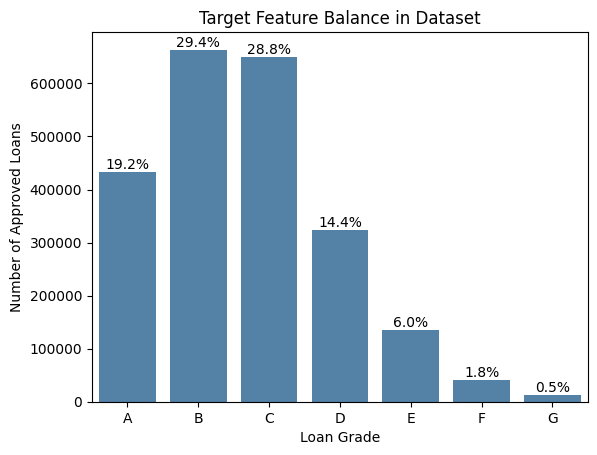

In [33]:
ax = sns.barplot(data=df, x=df_sorted.index, y=df_sorted.values, color="steelblue")

for c in ax.containers:
    ax.bar_label(c, fmt=lambda v: f"{(v/len(df))*100:0.1f}%")

ax.set_title("Target Feature Balance in Dataset")
ax.set_ylabel("Number of Approved Loans")
ax.set_xlabel("Loan Grade");

B and C grade loans together account for around 60% of the approved loans. Sharp decrease in percentage for lower end loan grades with E,F and G grade loans only accounting for less than 9% of all approved loans. It might be challenging to accurately classify among the lower grade loans.

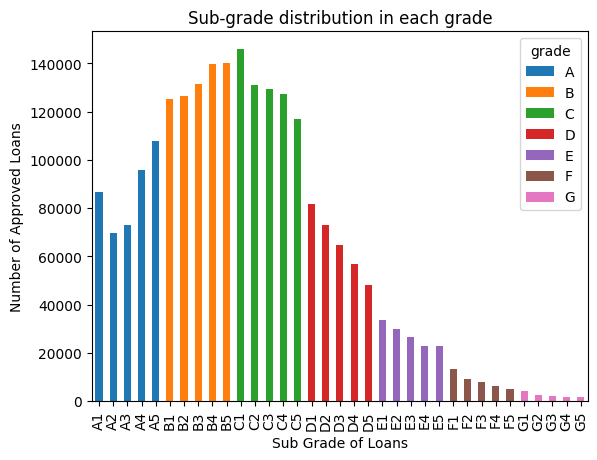

In [34]:
pd.crosstab(df["sub_grade"], df["grade"]).plot(kind="bar", stacked=True)
plt.title("Sub-grade distribution in each grade", fontsize=12)
plt.ylabel("Number of Approved Loans")
plt.xlabel("Sub Grade of Loans");

Loan sub grade distribution within loan grade buckets reflect on the observed loan grade distribution. Visually C1 sub grade loans seem to be the most popular product on Lending Club platform.

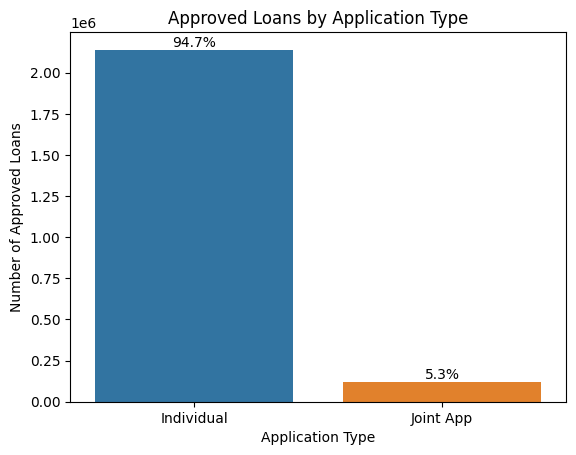

In [35]:
ax = sns.countplot(df, x=df["application_type"])
for c in ax.containers:
    ax.bar_label(c, fmt=lambda v: f"{(v/len(df))*100:0.1f}%")

ax.set_title("Approved Loans by Application Type")
ax.set_ylabel("Number of Approved Loans")
ax.set_xlabel("Application Type");

Seems only a very small portion of all approved loans are of joint type. It will be interesting to investigate if the application type has an impact on the loan grade decision when we move to machine learning part.

In part 1 of the project we have saw exponential growth of overall loan applications which then reflects in overall accepted to rejeced loan application ratio. Lets see if loan grades changed through the years as well.

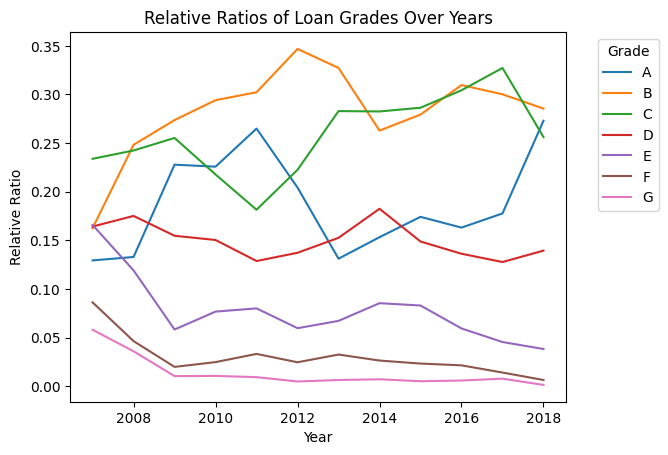

In [36]:
relative_ratios = (
    df.groupby(["Year", "grade"]).size() / df.groupby("Year").size()
).reset_index(name="Relative Ratio")

ax = sns.lineplot(data=relative_ratios, x="Year", y="Relative Ratio", hue="grade")

ax.set_title("Relative Ratios of Loan Grades Over Years")
ax.set_ylabel("Relative Ratio")
ax.set_xlabel("Year")
ax.legend(title="Grade", bbox_to_anchor=(1.05, 1), loc="upper left");

We can see fluctuations in higher grade loans, but there is no clear trend, however lower grade loans seem to account for a higher portion of all approved loans in the earlier years of LendingClub business. A quick drop around the time LendingClub were ordered to register with SEC and an official oversight started, then a steady decline with each pf the three lowest grade loan types reaching their smallest value.

Average approved loan amount: 15046.93 USD


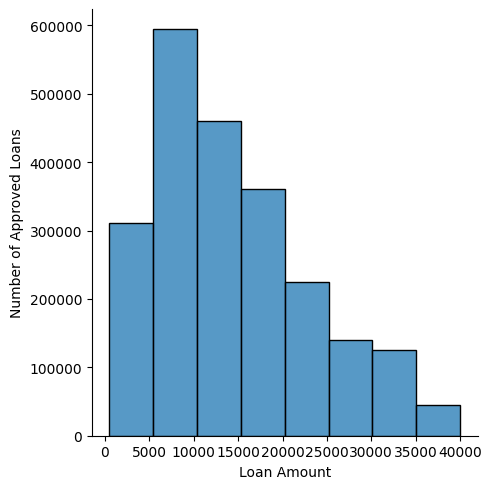

In [37]:
ax = sns.displot(df,x="loan_amnt", bins=8)
ax.set_titles("Distribution of Approved Loan Amount")
ax.set_ylabels("Number of Approved Loans")
ax.set_xlabels("Loan Amount")

print(f"Average approved loan amount: {df['loan_amnt'].mean():.2f} USD")

We can see that the loan amount distribution is normal with a right skew also that there are not too many loans above 40 000 dollars

Lowest interest rate of approved loan: 5.31%
Highest interest rate of approved loan: 30.99%


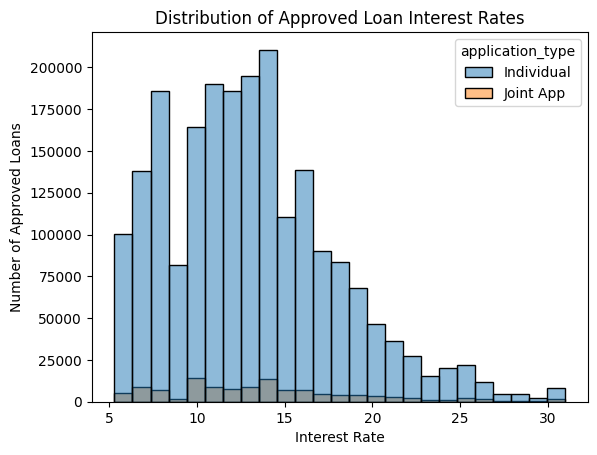

In [38]:
ax = sns.histplot(
    df,
    x="int_rate",
    bins=25,
    hue="application_type",
)

ax.set_title("Distribution of Approved Loan Interest Rates")
ax.set_ylabel("Number of Approved Loans")
ax.set_xlabel("Interest Rate")

print(f"Lowest interest rate of approved loan: {df['int_rate'].min()}%")
print(f"Highest interest rate of approved loan: {df['int_rate'].max()}%")

Interest rates for approved loans are roughly normally distributed with a right skew which is the same shape we can observe in loan grade and subgrade counts as grade and sub-grade drive the interest rate numbers. 

Joint application type loan interest rates also taper off for the higher interest rates, but does not have any particular pattern that would stand out.

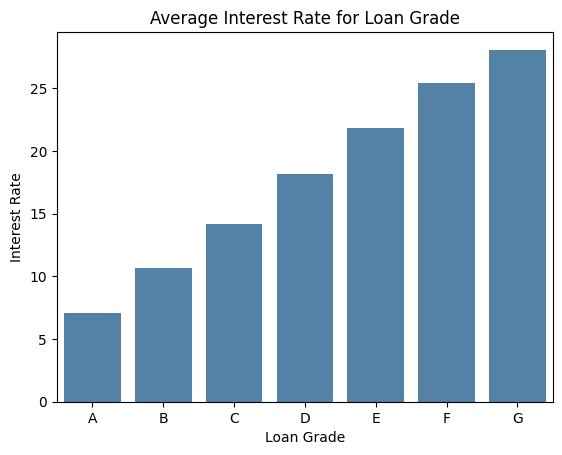

In [39]:
ax = sns.barplot(
    data=df,
    x="grade",
    y="int_rate",
    ci=None,
    estimator="mean",
    order=sorted(df["grade"].unique()),
    color='steelblue'
)

ax.set_title("Average Interest Rate for Loan Grade")
ax.set_ylabel("Interest Rate")
ax.set_xlabel("Loan Grade");

The interest rates for loans have a linear relationship with loan grade, lower the loan grade (alphabetically) highers the risk of loan default, thus higher the interest rate

In the first part we determined that some of the most important features for predicting the outcome of the loan is the fico score, loan amount and debt to income ratio. Continuing the logic lets have a look at how well do these features separate the loan grades. This will give us an idea on how difficult our classification task will be.

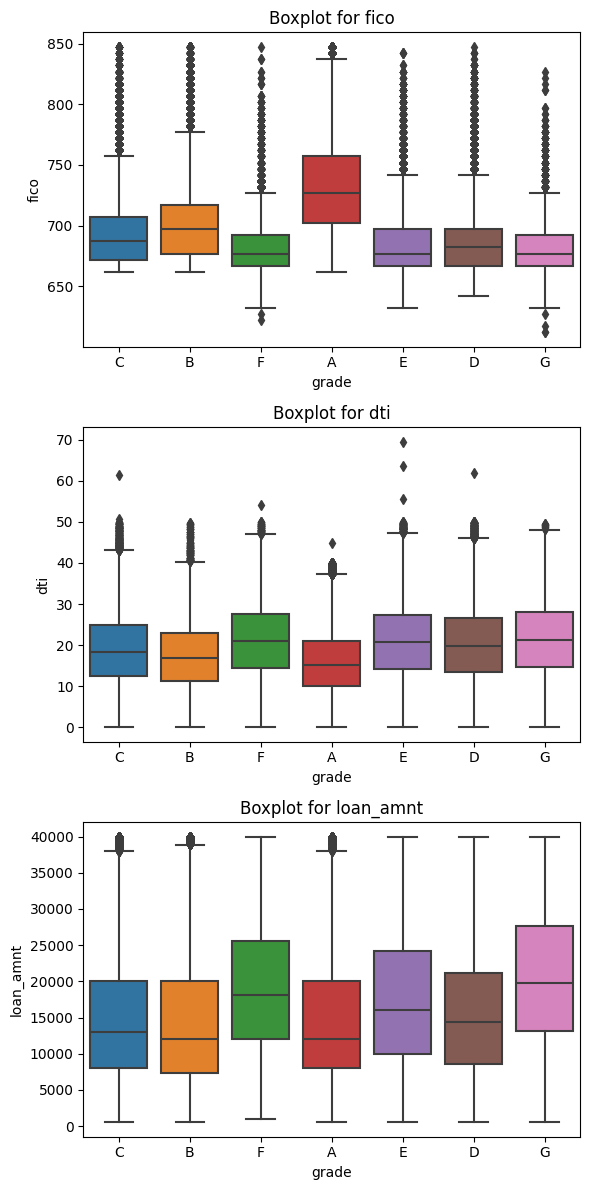

In [58]:
plot.boxplots(df,x_column='grade',y_columns=['fico','dti','loan_amnt'])

Apart from grade A loans the rest of the grades do not have a very clear separation within the main features, the median values in all three categories for mid grade (B,C,D,E) loans are close. We can expect the multiclass classification task to be quite difficult and extra features will definitely be needed.

Loans within the dataset are also categorized by the declared purpose, lets have a look at the distribution to see whatwere the loans for.

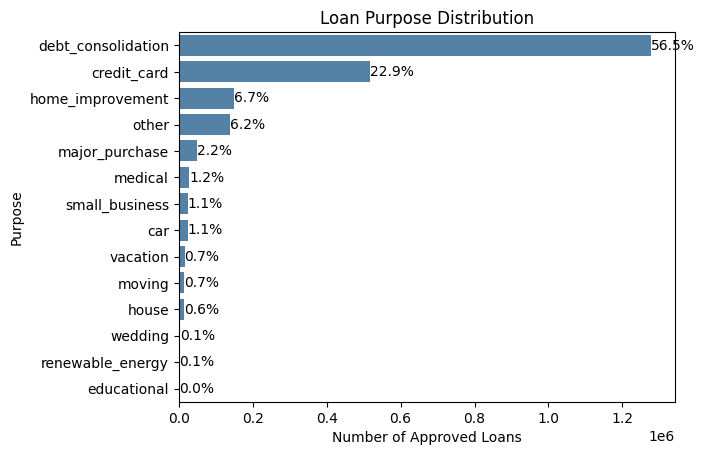

In [59]:
purpose_df = df["purpose"].value_counts().to_frame().reset_index()
ax = sns.barplot(purpose_df, x="count", y="purpose", color="steelblue")
for c in ax.containers:
    ax.bar_label(c, fmt=lambda v: f"{(v/len(df))*100:0.1f}%")

ax.set_title("Loan Purpose Distribution")
ax.set_ylabel("Purpose")
ax.set_xlabel("Number of Approved Loans");

Seems like the top two categories indicate that around 80% of the approved loans are used to cover debts (debt consolidation and credit card cover). Good insight, but not that useful for the task at hand

Since Lending Club is approved by the SEC to operate within federal jurisdiction lets have a look at some of the key metrics of loans issued by states of US. Since interest rate is the main factor that is determined by grade and sub-grade we can have a look at top 5 and lowest 5 average interest rates by state to see if there is any indication of significant difference.

In [63]:
res=df.groupby('addr_state')['int_rate'].agg('mean').sort_values(ascending=False).to_frame()
state_int=pd.concat([res.head(),res.tail()])

In [64]:
print(f"Highest average interest rate by state {res['int_rate'].max():.2f}%")
print(f"Lowest average interest rate by state {res['int_rate'].min():.2f}%")

Highest average interest rate by state 13.79%
Lowest average interest rate by state 12.58%


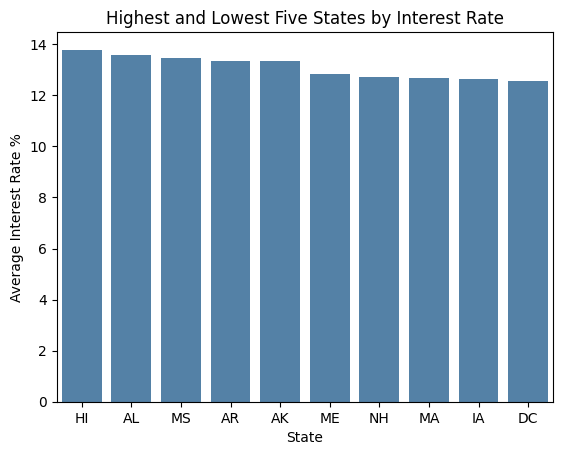

In [65]:
ax=sns.barplot(state_int,x=state_int.index,y='int_rate',color='steelblue')
ax.set_title('Highest and Lowest Five States by Interest Rate')
ax.set_ylabel('Average Interest Rate %')
ax.set_xlabel('State');

As we can observe there is no significant difference by top and bottom  states in interest rate. As the plaform is governed by a federal branch this is to be expected, no discrimination by geographic location. It is not worth chasing a geographical feature for the machine learning model.

#### EDA summary

- There is an inbalance of accepted loan grades in the dataset, with three lowest grade loans only accounting for ~9% of all accepted loans from 2008 to 2018
- There is an observable continous decline of issued lowest grade loans from year 2009, potentially related to LendingClub registering with SEC and reducing risk profiles of financial products.
- Average approved loan amount - 15 000 USD
- Highest issued loan interest rate: 30.99%, lowest: 5.31% 
- Around 80% of all accepted loans fall under debt consolidation and credit card payment purposes
- The difference of highgest average loan interest rate and lowest avearge interest rate by US state is 1.21%. The highest two interest rate states are Hawaii, Alaska - remote states with isolated economy is most likely a contributing factors. It does not seem that there are any other stand out states that would indicate preference or higher/lower risk assumptions from Lending Club.

#### Feature correlation

To check the feature correlation and understand feature relations further we will use phik library which will allow us to perform correlation on both categorical and numerical features.

In [66]:
num_cols = [
    "loan_amnt",
    "term",
    "dti",
    "fico",
    "total_acc",
    "emp_length",
    "delinq_2yrs",
    "open_acc",
    "pub_rec",
    "pub_rec_bankruptcies",
]
cat_cols = ["home_ownership", "verification_status", "purpose", "application_type"]

In [67]:
phik_overview = df.phik_matrix(interval_cols=num_cols)

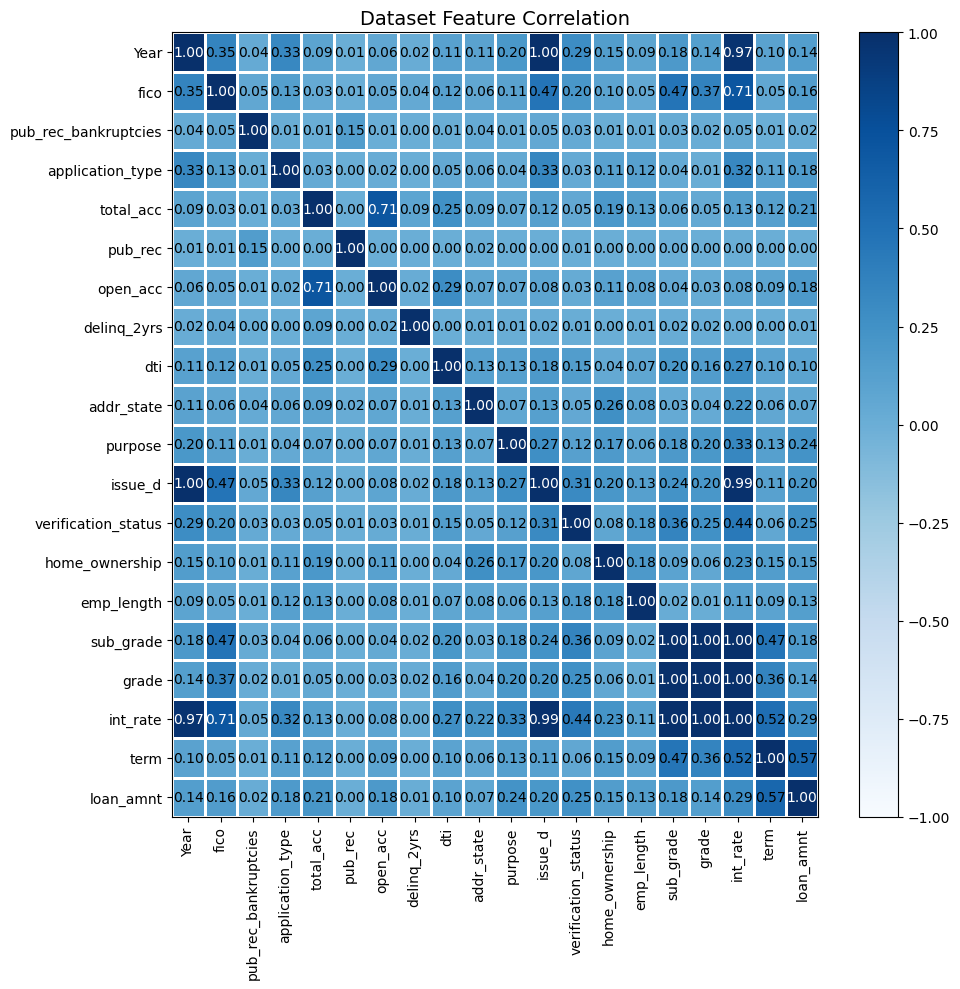

In [68]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    color_map="Blues",
    title="Dataset Feature Correlation",
    figsize=(10, 10),
)

Interesting correlation between interest rate and date (both issue date and year), this would suggest that interest rate was increasing year on year same as the numerical value of date feature.

Nothing else stands out in particular except for clustered grade/sub-grade and interest rate correlations which makes sense as sub grade and interest rate are derived from loan grade.

Total accounts and open accounts are also highly correlated as expected since total accounts takes into consideration the open accounts.

Fico and interest rate also shows high correlation as expected, it is no secret that FICO risk score is a big contributing factor for loan evaluation.


## Hypothesis testing

To build further understanding into some of the features we will perform a few hypothesis tests, mainly focusing on purpose of loans, interest rate and debt to income ratios.

#### Hypothesis 1

As seen in part 1 Lending club went through expontential growth in loan applications from year 2012, around 2015 the volume of annual loan applications already exceeded 2 million and the trendline for number of approved loans flattened. Lets check if the interest rate has significantly changed for approved loans from when the company has matured to the last few years. This will also serve as feature importance check for our ML models.


Ho- There is no statistically significant difference in interest rate for applications between years 2015-2016 and years 2017-2018.

Alternative hypothesis- There is a statistically significant difference in interest rat for applications between years 2015-2016 and years 2017-2018.

Levene's test for group variance equality and t-Test double tailed test for mean difference will be used

In [69]:
group1=df[(df['Year']>=2015)&(df['Year']<=2016)]['int_rate']
group2=df[df['Year']>=2017]['int_rate']

statistic, p_value = stats.levene(group1, group2)

alpha = 0.05 
print(f"Levene's test p-value: {p_value}")

Levene's test p-value: 0.0


With Levene's test p-values below the significance threshold of 0.05 the variance of two groups is significantly different.

In [70]:
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  

print(f"P-value: {p_value}")



P-value: 2.914156001622852e-91


With the t-Test p-value below the 0.05 significance threshold we can infer that there is a statistically significant difference in interest rates for loan applications between years 2015-2016 and years 2017-2018.

Year feature is expected to be useful in loan grade/sub-grade and interest rate prediction models.

#### Hypothesis 2

Paying off credit cards is sometimes done using other credit cards or a simple consumer loans. In the dataset there are debt consolidation and credit card purposes, so it would be interesting to see if applicants stating these purposes for loans are actually in the same financial situation debt to income ratio-wise.

Ho: There is no significant difference in debt to income ratio for applicants getting loans for debt consolidation and applicant getting loans for credit card refinancing.

H1: There is a significant difference in debt to income ratio for applicants getting loans for debt consolidation and applicant getting loans for credit card refinancing.

With the large enough data sample for both groups we will use t-Test mean difference test with significance level alpha of 0.05

In [71]:
group1 = df[df["purpose"] == "debt_consolidation"]["dti"]
group2 = df[df["purpose"] == "credit_card"]["dti"]

Quickly check if both groups have aproximately equal variance. The same significance threshold alpha of 0.05 will be used. If the value is above the alpha threshold we can consider both variances proximately similar.

In [72]:
statistic, p_value = stats.levene(group1, group2)

alpha = 0.05 
print(f"Levene's test p-value: {p_value}")

Levene's test p-value: 0.25957474689250126


In [73]:
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)  

print(f"P-value: {p_value}")

if p_value < 0.05:
    print(
        f"Reject the null hypothesis of no statistically significant difference between the two groups."
    )
else:
    print(
        f"Cannot reject the null hypothesis of no statistically significant difference between the two groups."
    )

P-value: 1.2947209895869847e-131
Reject the null hypothesis of no statistically significant difference between the two groups.


With the observed p value way lower than the pre-set significance level of 0.05, we can infer that there is a statistically significant difference in debt to income ratios between applicants stating debt consolidation or credit card as purpose for the loan.


## Machine Learning 

With the task at hand of multiclass classification we will set a baseline model using a multinomial LogisticRegression model using F1 macro score. The final model will be built using LightGBM as in part 1, hyperparameter tuning will be done using Bayesian Optimisation tool Optuna.

F1 Macro score was chosen as the main metric due to the fact that loan grade is a contributing factor to other evaluation criteria like sub-grade and interest rate. For the business to manage the risk it is exposing their funding customers to it is important to classify each loan grade category correctly, so we are interested in both precision and recall for each grade class.

Since computational resources are limited a random sample from the already cleaned dataframe will be sampled and all modeling done on the sample. 

### Data preparation

We will take a smaller sample from the original dataframe do be used in feature importance check with a Random Forest Classifier model to determine which feature we could potentially drop out of the final model

In [74]:
df['term'], df['emp_length'] = df['term'].astype(float), df['emp_length'].astype(float)

In [75]:
df = df.drop_duplicates()

Dropping high cardinality features and features which would introduce data leakage.

In [76]:
df = df.drop(
    columns=["purpose", "addr_state", "int_rate", "sub_grade","issue_d"]
)

Lets quickly investigate if the target feature ratio is close to the full dataset.

In [77]:
df["grade"].value_counts(normalize=True)

grade
B   0.29
C   0.29
A   0.19
D   0.14
E   0.06
F   0.02
G   0.01
Name: proportion, dtype: float64

In [78]:
X = df.drop(["grade"], axis=1)
y = df["grade"]

### Build the pipeline

In [79]:
num_cols = [
    "loan_amnt",
    "term",
    "dti",
    "total_acc",
    "fico",
    "emp_length",
    "delinq_2yrs",
    "open_acc",
    "pub_rec",
    "pub_rec_bankruptcies",
    "Year",
]
cat_cols = ["home_ownership", "verification_status", "application_type"]

In [80]:
numerical_transformer = Pipeline([("scaler", StandardScaler())])
categorical_tranformer = Pipeline([("encoder", OneHotEncoder())])

In [81]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numerical_transformer, num_cols),
        ("cat", categorical_tranformer, cat_cols)
    ]
)

### Baseline model and feature selection

To optimize the model we will perform a feature selection step using a LightGBM classifier. We will evaluate the model logic using SHAP values and select the features for the final model accordingly.

In [82]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(random_state=RANDOM_SEED,verbose=-1),
        ),
    ]
)

We will split the dataset and fit the baseline model to get some metrics out

In [125]:
X_train,X_test,y_train,y_test=utl.sample_and_split(df,'grade',n=500000,random_seed=RANDOM_SEED)

In [126]:
baseline_clf=pipe.fit(X_train,y_train)

In [127]:
y_pred = baseline_clf.predict(X_test)
print(f"Macro F1 score for baseline model:{f1_score(y_test,y_pred,average='macro'):.2f}")

Macro F1 score for baseline model:0.32


And we can have a look at a normalized confusion matrix

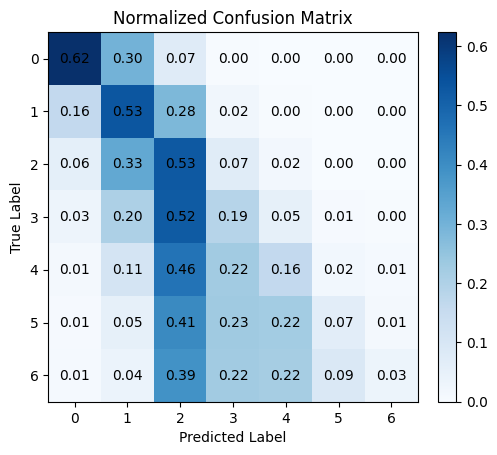

In [128]:
plot.norm_confusion_plot(y_test,y_pred,np.sort(np.unique(y.values)))

#### Feature importance

We can have a look at shapley values for the model and decide which features we will ommit from the final model based on impact values

In [87]:
shap.initjs()

In [88]:
preprocessor = baseline_clf.named_steps["preprocessor"]

In [89]:
ohe_categories = preprocessor.named_transformers_["cat"][0].categories_
new_ohe_features = [
    f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals
]
all_features = num_cols + new_ohe_features

In [90]:
explainer = shap.TreeExplainer(baseline_clf["classifier"])

In [91]:
observations = baseline_clf["preprocessor"].transform(
    X_train.sample(500, random_state=RANDOM_SEED)
)
shap_values = explainer.shap_values(observations)

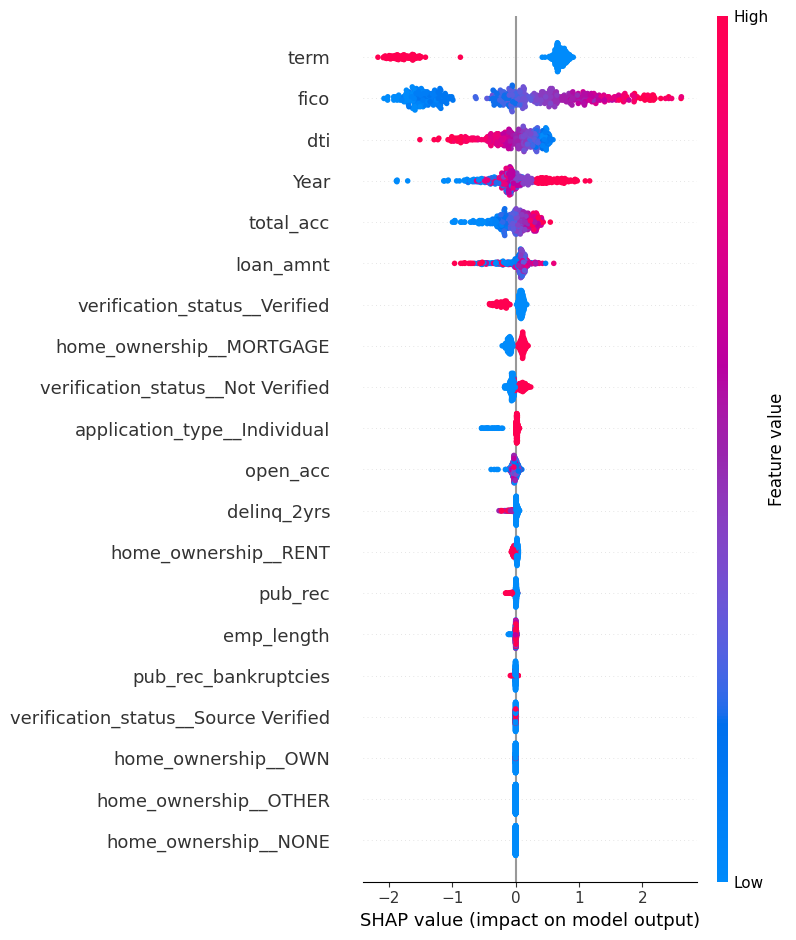

In [92]:
shap.summary_plot(shap_values[0], features=observations, feature_names=all_features)

Above visualization shows the impact of each feature in the model explained by SHAP value. Term, FICO score, Year of loan issue, debt to income ratio are the top features of importance. 

Top features with highest spread from the neutral impact on model axis are loan term, fico score, year of loan application, debt to income ratio, loan amount and total open credit accounts. The year feature is interesting, the pattern that is encoded in year is most likely reflecting the macroeconomic conditions of the particular time, we will try and investigate this feature in part 3 of the project.

We can also see that there are a lot of the features that have minimal or no impact on the model, we can lighten up the final model by removing them.

In [93]:
low_impact_features = [
    "emp_length",
    "delinq_2yrs",
    "open_acc",
    "pub_rec",
    "pub_rec_bankruptcies",
    "application_type"]

In [94]:
df=df.drop(columns=low_impact_features)

In [95]:
X = df.drop(["grade"], axis=1)
y = df["grade"]

In [96]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numerical_transformer, ['loan_amnt','term','dti','total_acc','fico','Year']),
        ("cat", categorical_tranformer, ['home_ownership','verification_status'])
    ]
)

Split the sample dataset into train/validation and test partitions 60%/20%/20% respective.

In [97]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_SEED
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)

### LighGBM model

Same as in the part 1 of the project we will use LightGBM classifier classify loan grades. 

Defining the parameter grid for Optuna 

In [98]:
def objective(trial):
    param = {
        "objective": "multiclass",
        "num_class": 7,
        "boosting_type": "gbdt",
        "metric": "multi_logloss",
        "verbose": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 31, 128),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 10000, 40000),
        "n_estimators": trial.suggest_int("n_estimators", 2, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 19),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
        "min_chil_weight": trial.suggest_float("min_child_weight", 0.001, 0.005),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }


    model = LGBMClassifier(**param)
    model.fit(preprocessor.fit_transform(X_train), y_train)
    predictions = model.predict(preprocessor.fit_transform(X_val))
    f1_macro = f1_score(y_val, predictions, average="macro")
    return f1_macro

Run the study

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

In [100]:
print(study.best_value)

0.32596571849433387


Finishing off the final model and building the pipeline before saving

In [101]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LGBMClassifier(**study.best_params, verbose=-1)),
    ]
)

In [102]:
grade_clf = pipe.fit(X_train, y_train)

In [103]:
y_pred=grade_clf.predict(X_val)

Normalized confusion matrrix for the validation set with tuned classifier

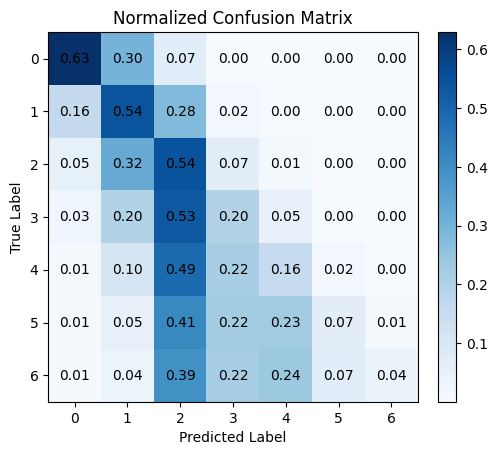

In [124]:
plot.norm_confusion_plot(y_val,y_pred,np.sort(np.unique(y.values)))

As already seen from the scores the classificator is struggling to classify all loan grades correctly. Especially lower grades which for there are very few predictions in total. 



### Final model scoring

In [106]:
y_test_pred = grade_clf.predict(X_test)

In [121]:
print(
    f"Macro F1 score of the final model on test holdout set:{f1_score(y_test,y_test_pred,average='macro')*100:.2f}"
)

Macro F1 score of the final model on test holdout set:32.33


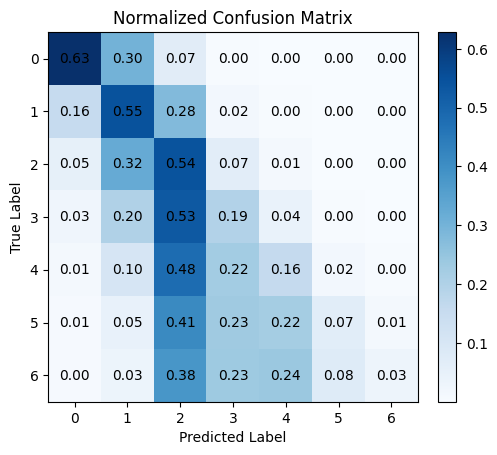

In [123]:
plot.norm_confusion_plot(y_test,y_test_pred,np.sort(np.unique(y.values)))

We can see the same pattern as in the holdout set - no predictions of minority classes (F and G loans), slightly better results on A,B an C loan grades. 

In [119]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           A       0.65      0.63      0.64     86205
           B       0.46      0.55      0.50    132485
           C       0.43      0.54      0.48    130340
           D       0.39      0.19      0.26     65075
           E       0.37      0.16      0.22     27117
           F       0.34      0.07      0.11      8483
           G       0.16      0.03      0.05      2428

    accuracy                           0.48    452133
   macro avg       0.40      0.31      0.32    452133
weighted avg       0.47      0.48      0.46    452133



Save the model

In [ ]:
filename = 'grade_clf.sav'
joblib.dump(grade_clf, filename)

### Conclusions

Approved loan dataset from LendingClub was analyzed, EDA performed and a model using LightGBM classifier was created to classify the loan grades for the approved loans. 

Tuned multiclass classificator validation F1 Macro score:32%
Tuned multiclass classificator test F1 Macro score: 32%

The model is was not overfitting the training set.

Overall the model performance is not satisfactory which can be attributed to high number of unique loan grades, imbalance of the dataset for the loan grade and possible fluctuations in the credit policy throughout the years.

Some more work is needed with domain experts to engineer better features and potentially focusing the model on the shorter timespan to reflect the changes in economic factors and policy changes. Also since date feature is used for prediction, the model would need to be retrained with incoming production data.